<a href="https://colab.research.google.com/github/Attabeezy/sequential-crm-for-dce/blob/main/credit_risk_prediction_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, classification_report
import warnings
import io

warnings.filterwarnings('ignore') # for suppressing warnings. cleaner output

##Setup and Data Loading

In [ ]:
file_path = "/content/drive/MyDrive/Colab_Notebooks/yara/lending_club_loan_two.csv"

df = pd.read_csv(file_path)

if df is not None:
    print("Data loaded successfully.")
else:
    print("Failed to load data.")

df.shape

df.head()

Data loaded successfully.


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


## Data Preprocessing

In [ ]:
## TARGET VARIABLE AND INITIAL FILTER
# MAP LOAN_STATUS TO BINARY TARGET VARIABLE. WITH 0=DEFAULT AND 1=NOT DEFAULT
# CONSIDERING FULLY PAID AS NOT DEFAULT AND VICE VERSA FOR CHARGED OFF

df_clean = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()
df_clean['loan_status_binary'] = df_clean['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

# Separate features and target before splitting
X_clean = df_clean.drop('loan_status_binary', axis=1)
y_clean = df_clean['loan_status_binary']


# SPLITTING DATA INTO TRAIN AND TEST TESTS STRATIFIED BY LOAN STATUS
# This ensures both classes are present in train and test sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)


SAMPLE_SIZE = 180000 # paper used a sample size of 60,000 records

if len(X_train_full) > SAMPLE_SIZE:
    # Sample from the full training set
    train_indices = X_train_full.sample(n=SAMPLE_SIZE, random_state=42).index
    df_sampled = df_clean.loc[train_indices].copy()
    print(f"Data sampled to {SAMPLE_SIZE} records from the training set.")
else:
    # Use the full training set if its smaller than SAMPLE_SIZE
    df_sampled = df_clean.loc[X_train_full.index].copy()
    print(f"Data has {len(df_sampled)} records. No sampling performed.")

# Recombine features and target for the sampled data
X_sampled = df_sampled.drop('loan_status_binary', axis=1)
y_sampled = df_sampled['loan_status_binary']


## FEATURE SELECTION AND CLEANING
# SELECTING FEATURES USED IN PAPER
FEATURE_COLUMNS = [
    'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
    'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'annual_inc', 'application_type'
]

# CHECK FOR COLUMNS AVAILABILITY BASED ON RESEARCH PAPERS SELECTIONS
available_cols = [col for col in FEATURE_COLUMNS if col in X_sampled.columns]

if len(available_cols) == len(FEATURE_COLUMNS):
    print("All columns are available.")
else:
    missing_cols = set(FEATURE_COLUMNS) - set(available_cols)
    print(f"The following columns are missing: {missing_cols}")

# CLEANING CATEGORICAL AND STRING COLUMNS TO BE NUMERIC
# 1. 'term': Remove 'months' and convert to float
if 'term' in X_sampled.columns:
    if X_sampled['term'].dtype == 'object': # Check if the column is of string type
        X_sampled['term'] = X_sampled['term'].str.replace(' months', '', regex = False).astype(float)
    else:
        print("Warning: 'term' column is not of string type. Skipping string cleaning.")


# 2. 'int_rate': Remove percentage and convert to float
if 'int_rate' in X_sampled.columns:
    if X_sampled['int_rate'].dtype == 'object': # Check if the column is of string type
        X_sampled['int_rate'] = X_sampled['int_rate'].str.replace('%', '', regex = False).astype(float)
    else:
         print("Warning: 'int_rate' column is not of string type. Skipping string cleaning.")

# 3. 'emp_length': convert strings to numeric (0-10)
if 'emp_length' in X_sampled.columns:
    if X_sampled['emp_length'].dtype == 'object': # Check if the column is of string type
        X_sampled['emp_length'] = X_sampled['emp_length'].replace({
            '< 1 year': '0', '1 year': '1', '2 years': '2', '3 years': '3', '4 years': '4',
            '5 years': '5', '6 years': '6', '7 years': '7', '8 years': '8', '9 years': '9',
            '10+ years': '10', 'n/a': np.nan
        }).astype(float)
    else:
        print("Warning: 'emp_length' column is not of string type. Skipping string cleaning.")


# SELECT FINAL WORKING FEATURES
final_features = [col for col in available_cols if X_sampled[col].dtype in ['float64', 'int64']]
# ALSO INCLUDE CATEGORICAL FEATURES THAT NEED ONE-HOT ENCODING
categorical_features = ['grade', 'application_type']
final_features.extend([c for c in categorical_features if c in X_sampled.columns])

X_final = X_sampled[final_features].copy()
y_final = y_sampled.copy()

# Drop NaNs after selecting final features
combined_df = pd.concat([X_final, y_final], axis=1)
combined_df.dropna(inplace=True)

X_final = combined_df.drop('loan_status_binary', axis=1)
y_final = combined_df['loan_status_binary']

print(f"Data after cleaning and dropping NaNs: {X_final.shape[0]} records.")

# ONE-HOT ENCODE CATEGORICAL VARIABLES ('grade', 'application_type')
X_encoded = pd.get_dummies(X_final, columns = [c for c in categorical_features if c in X_final.columns], drop_first=True)
X = X_encoded.copy()
y = y_final.copy()
print(f"Total input features after one-hot encoding: {X.shape[1]}")


## SPLITTING AND NORMALIZATION (Min-Max)
# Use the stratified test set created earlier
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# NORMALIZING FEATURES WITH Min-Max Linear Transformation
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Train/Test split: {X_train.shape[0]} / {X_test.shape[0]} samples.")
print("Features normalized (0 to 1) using Min-Max scaler.")

Data sampled to 180000 records from the training set.
The following columns are missing: {'funded_amnt', 'funded_amnt_inv'}
Data after cleaning and dropping NaNs: 171696 records.
Total input features after one-hot encoding: 14
Train/Test split: 137356 / 34340 samples.
Features normalized (0 to 1) using Min-Max scaler.


## Artificial Neural Network (ANN) Implementation

In [ ]:
# ANN Architecture
input_dim = X_train_scaled.shape[1]
hidden_neurons = 7 #testing number, may adjust

model = tf.keras.Sequential([
    # Input Layer (implicitly defined by input_shape) -> Hidden Layer (7 neurons)
    tf.keras.layers.Dense(hidden_neurons, activation='relu', input_shape=(input_dim,)),
    # Output Layer (1 neuron for binary classification)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compiling model with Adam for backpropagation
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train model
print(f"Training ANN with {input_dim} inputs, 1 hidden layer of {hidden_neurons} neurons, and 1 output.")
history = model.fit(X_train_scaled, y_train,
                    epochs = 50, #testing number, may adjust
                    batch_size = 32, #testing number, may adjust
                    validation_data = (X_test_scaled, y_test)
                    )

# Make predictions and evaluate
y_pred_ann_proba = model.predict(X_test_scaled).flatten()
y_pred_ann = (y_pred_ann_proba > 0.5).astype(int)

ann_accuracy = accuracy_score(y_test, y_pred_ann)
ann_mse = mean_squared_error(y_test, y_pred_ann_proba) # MSE for prob of output

print(f"ANN test accuracy: {ann_accuracy}")
print(f"ANN test MSE: {ann_mse}")

Training ANN with 14 inputs, 1 hidden layer of 7 neurons, and 1 output.
Epoch 1/50
4293/4293 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7929 - loss: 0.5019 - val_accuracy: 0.8070 - val_loss: 0.4554
Epoch 2/50
4293/4293 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8058 - loss: 0.4593 - val_accuracy: 0.8068 - val_loss: 0.4528
Epoch 3/50
4293/4293 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8070 - loss: 0.4554 - val_accuracy: 0.8070 - val_loss: 0.4529
Epoch 4/50
4293/4293 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8077 - loss: 0.4513 - val_accuracy: 0.8069 - val_loss: 0.4523
Epoch 5/50
4293/4293 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8068 - loss: 0.4541 - val_accuracy: 0.8070 - val_loss: 0.4521
Epoch 6/50
4293/4293 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8059 - loss: 0.4548 - val_accuracy: 0.8072 - val_loss: 0.4520
Epoch 7/50
4293/4293 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8074 - loss: 0.4537 - val_accuracy: 0.8073 - val_loss: 0.4517
Epoch 8/50


## Logistic Regression Implementation


In [ ]:
# LR as stand-in for paper's GLM/Linear Regression for classification
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Apply the 0.5 probability cutoff for classification
y_pred_lr = (y_pred_lr_proba > 0.5).astype(int)

lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_mse = mean_squared_error(y_test, y_pred_lr_proba)

print(f"Logistic Regression test accuracy: {lr_accuracy:.6f}")
print(f"Logistic Regression test MSE: {lr_mse:.7f}")

Logistic Regression test accuracy: 0.806931
Logistic Regression test MSE: 0.1434431


## Evaluation and Comparison

In [ ]:
# Comparison Table (Table 2 from paper)
print("\nTable: Mean Squared Error of both processes (Replication)")
print(pd.DataFrame({
    'Model': ['MSE of ANN', 'MSE of Logistic Regression'],
    'Mean Squared Error': [ann_mse, lr_mse]
}))

# Confusion Matrix (Fig. 6 for Logistic Regression from paper)
cm = confusion_matrix(y_test, y_pred_lr)
lr_report = classification_report(y_test, y_pred_lr, output_dict=True, zero_division=0)
lr_acccuracy = lr_report['accuracy']

# Formatting Fig. 6 from paper (Prediction vs. Reference)
print("\nFig. 6. Confusion Matrix and Statistics of Logistic Regression")
confusion_df = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'])
confusion_df.index = ['Reference 0', 'Reference 1'] # Set index names for 'Reference'

print("\nReference")
print(confusion_df)
print(f"\nAccuracy: {lr_acccuracy:.7f}")

# Overall Conclusion
print("\nOverall Conclusion")
print(f"ANN achieved accuracy: {ann_accuracy:.6f}",
      f"\nANN achieved MSE: {ann_mse:.7f}")
print(f"Logistic Regression achieved accuracy: {lr_acccuracy:.6f}",
      f"\nLogistic Regression achieved MSE: {lr_mse:.7f}")

if np.isclose(ann_accuracy, lr_accuracy, atol=0.005):
    print("\nResult: Both models show approximately similar performance.")
elif ann_accuracy > lr_accuracy:
    print("\nResult: ANN outperforms Logistic Regression.")
else:
    print("\nResult: Logistic Regression outperforms ANN.")


Table: Mean Squared Error of both processes (Replication)
                        Model  Mean Squared Error
0                  MSE of ANN            0.143054
1  MSE of Logistic Regression            0.143443

Fig. 6. Confusion Matrix and Statistics of Logistic Regression

Reference
             Predicted 0  Predicted 1
Reference 0            9         6618
Reference 1           12        27701

Accuracy: 0.8069307

Overall Conclusion
ANN achieved accuracy: 0.807484 
ANN achieved MSE: 0.1430541
Logistic Regression achieved accuracy: 0.806931 
Logistic Regression achieved MSE: 0.1434431

Result: Both models show approximately similar performance.


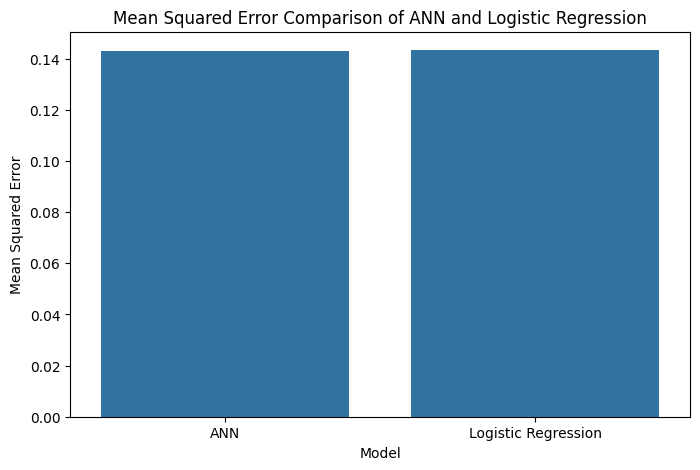

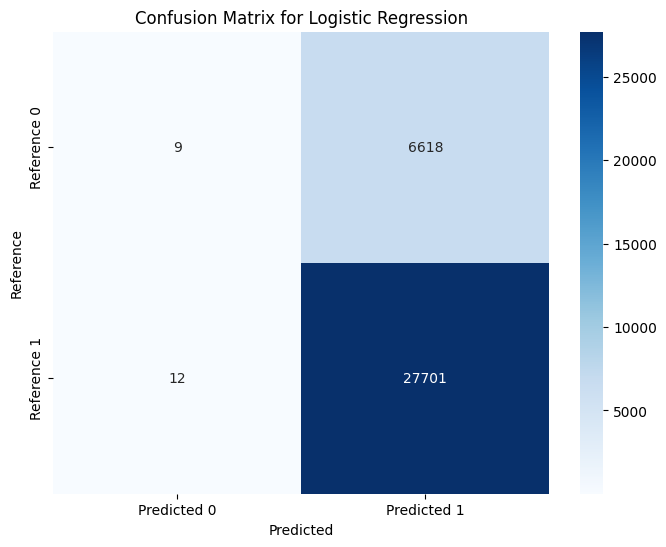

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize MSE comparison
mse_df = pd.DataFrame({
    'Model': ['ANN', 'Logistic Regression'],
    'Mean Squared Error': [ann_mse, lr_mse]
})

plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Mean Squared Error', data=mse_df)
plt.title('Mean Squared Error Comparison of ANN and Logistic Regression')
plt.ylabel('Mean Squared Error')
plt.show()

# Visualize Logistic Regression Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Reference')
plt.show()

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# DATA LOADING
# ============================================================================
file_path = "/content/drive/MyDrive/Colab_Notebooks/yara/lending_club_loan_two.csv"
df = pd.read_csv(file_path)
print(f"Initial data shape: {df.shape}")

# ============================================================================
# TARGET VARIABLE AND INITIAL FILTER - FIX THE SPACE ISSUE!
# ============================================================================
# Check unique values first
print(f"Unique loan_status values: {df['loan_status'].unique()}")

# FIX: Handle both with and without spaces
df_clean = df[df['loan_status'].str.strip().isin(['Fully Paid', 'Charged Off'])].copy()
print(f"After filtering loan_status: {df_clean.shape}")

# Map to binary (1=Fully Paid, 0=Charged Off/Default)
df_clean['loan_status_binary'] = df_clean['loan_status'].str.strip().apply(
    lambda x: 1 if x == 'Fully Paid' else 0
)

# Verify class distribution
print(f"\nClass distribution:\n{df_clean['loan_status_binary'].value_counts()}")
print(f"Class proportions:\n{df_clean['loan_status_binary'].value_counts(normalize=True)}")

# ============================================================================
# FEATURE SELECTION
# ============================================================================
FEATURE_COLUMNS = [
    'loan_amnt', 'term', 'int_rate', 'installment',
    'grade', 'emp_length', 'annual_inc', 'application_type'
]

# Check availability
available_cols = [col for col in FEATURE_COLUMNS if col in df_clean.columns]
print(f"\nAvailable features: {available_cols}")

X_initial = df_clean[available_cols].copy()
y_initial = df_clean['loan_status_binary'].copy()

# ============================================================================
# FEATURE CLEANING
# ============================================================================
# 1. Term: Remove 'months' and convert to numeric
if 'term' in X_initial.columns:
    X_initial['term'] = X_initial['term'].astype(str).str.replace(' months', '', regex=False)
    X_initial['term'] = pd.to_numeric(X_initial['term'], errors='coerce')

# 2. Interest rate: Remove '%' if present
if 'int_rate' in X_initial.columns and X_initial['int_rate'].dtype == 'object':
    X_initial['int_rate'] = X_initial['int_rate'].str.replace('%', '', regex=False)
    X_initial['int_rate'] = pd.to_numeric(X_initial['int_rate'], errors='coerce')

# 3. Employment length: Convert to numeric
if 'emp_length' in X_initial.columns:
    emp_length_map = {
        '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
        '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
        '10+ years': 10, 'n/a': np.nan
    }
    X_initial['emp_length'] = X_initial['emp_length'].astype(str).map(emp_length_map)

print(f"\nData shape after feature cleaning: {X_initial.shape}")

# ============================================================================
# HANDLE MISSING VALUES BEFORE SPLITTING
# ============================================================================
# Combine features and target to drop rows consistently
combined = pd.concat([X_initial, y_initial], axis=1)
print(f"Missing values before dropping:\n{combined.isnull().sum()[combined.isnull().sum() > 0]}")

combined_clean = combined.dropna()
print(f"\nShape after dropping NaNs: {combined_clean.shape}")

X_clean = combined_clean.drop('loan_status_binary', axis=1)
y_clean = combined_clean['loan_status_binary']

# Verify class balance after cleaning
print(f"\nClass distribution after cleaning:\n{y_clean.value_counts()}")
print(f"Class proportions:\n{y_clean.value_counts(normalize=True)}")

# ============================================================================
# ONE-HOT ENCODING
# ============================================================================
categorical_cols = ['grade', 'application_type']
categorical_cols = [c for c in categorical_cols if c in X_clean.columns]

X_encoded = pd.get_dummies(X_clean, columns=categorical_cols, drop_first=True)
print(f"\nFeatures after encoding: {X_encoded.shape[1]}")
print(f"Feature names: {list(X_encoded.columns)}")

# ============================================================================
# TRAIN-TEST SPLIT WITH STRATIFICATION
# ============================================================================
# Split first on the cleaned and encoded data
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_encoded, y_clean,
    test_size=0.2,
    random_state=42,
    stratify=y_clean
)

print(f"\nTrain set (full) class distribution:\n{y_train_full.value_counts()}")
print(f"Test set class distribution:\n{y_test.value_counts()}")

# ============================================================================
# OUTLIER REMOVAL (Only on training set)
# ============================================================================
X_train = X_train_full.copy()
y_train = y_train_full.copy()

if 'annual_inc' in X_train.columns:
    # Define outlier threshold
    annual_inc_threshold = 250000
    outlier_mask = X_train['annual_inc'] <= annual_inc_threshold
    X_train = X_train[outlier_mask]
    y_train = y_train[outlier_mask]
    print(f"\nAfter outlier removal (annual_inc <= {annual_inc_threshold}) - Train shape: {X_train.shape}")

# ============================================================================
# SAMPLING (If needed, sample from training set)
# ============================================================================
SAMPLE_SIZE = 60000
if len(X_train) > SAMPLE_SIZE:
    sample_indices = X_train.sample(n=SAMPLE_SIZE, random_state=42).index
    X_train = X_train.loc[sample_indices]
    y_train = y_train.loc[sample_indices]
    print(f"Sampled training data to {SAMPLE_SIZE} records")

print(f"\nFinal train set class distribution:\n{y_train.value_counts()}")

# ============================================================================
# NORMALIZATION
# ============================================================================
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Scale test set using scaler fitted on train set

print(f"\nFinal shapes - Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")

# ============================================================================
# ANN MODEL
# ============================================================================
input_dim = X_train_scaled.shape[1]
hidden_neurons = 7

model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_neurons, activation='relu', input_shape=(input_dim,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(f"\nTraining ANN with {input_dim} inputs, {hidden_neurons} hidden neurons, 1 output")

history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    verbose=0  # Set to 1 to see training progress
)

# ANN Predictions
y_pred_ann_proba = model.predict(X_test_scaled, verbose=0).flatten()
y_pred_ann = (y_pred_ann_proba > 0.5).astype(int)
ann_accuracy = accuracy_score(y_test, y_pred_ann)
ann_mse = mean_squared_error(y_test, y_pred_ann_proba)

print(f"\nANN Results:")
print(f"  Accuracy: {ann_accuracy:.4f}")
print(f"  MSE: {ann_mse:.6f}")

# ============================================================================
# LOGISTIC REGRESSION MODEL
# ============================================================================
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

y_pred_lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
y_pred_lr = (y_pred_lr_proba > 0.5).astype(int)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_mse = mean_squared_error(y_test, y_pred_lr_proba)

print(f"\nLogistic Regression Results:")
print(f"  Accuracy: {lr_accuracy:.4f}")
print(f"  MSE: {lr_mse:.6f}")

Initial data shape: (396030, 27)
Unique loan_status values: ['Fully Paid' 'Charged Off']
After filtering loan_status: (396030, 27)

Class distribution:
loan_status_binary
1    318357
0     77673
Name: count, dtype: int64
Class proportions:
loan_status_binary
1    0.803871
0    0.196129
Name: proportion, dtype: float64

Available features: ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'annual_inc', 'application_type']

Data shape after feature cleaning: (396030, 8)
Missing values before dropping:
emp_length    18301
dtype: int64

Shape after dropping NaNs: (377729, 9)

Class distribution after cleaning:
loan_status_binary
1    305094
0     72635
Name: count, dtype: int64
Class proportions:
loan_status_binary
1    0.807706
0    0.192294
Name: proportion, dtype: float64

Features after encoding: 14
Feature names: ['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'applicat

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC for ANN
fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_test, y_pred_ann_proba)
roc_auc_ann = auc(fpr_ann, tpr_ann)

# Calculate ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Calculate ROC curve and AUC for XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Display AUC results
print("AUC-ROC Scores:")
print(f"ANN: {roc_auc_ann:.4f}")
print(f"Logistic Regression: {roc_auc_lr:.4f}")
print(f"XGBoost: {roc_auc_xgb:.4f}")

# Optional: Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_ann, tpr_ann, color='darkorange', lw=2, label=f'ANN (AUC = {roc_auc_ann:.4f})')
plt.plot(fpr_lr, tpr_lr, color='green', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [75546, 34340]

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate ROC curve and AUC for ANN
fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_test, y_pred_ann_proba)
roc_auc_ann = auc(fpr_ann, tpr_ann)

# Calculate ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Calculate ROC curve and AUC for XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Display AUC results
print("AUC-ROC Scores:")
print(f"ANN: {roc_auc_ann:.4f}")
print(f"Logistic Regression: {roc_auc_lr:.4f}")
print(f"XGBoost: {roc_auc_xgb:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_ann, tpr_ann, color='darkorange', lw=2, label=f'ANN (AUC = {roc_auc_ann:.4f})')
plt.plot(fpr_lr, tpr_lr, color='green', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Re-run the data preprocessing and model training cells to ensure variables are defined
%run -i Bw8q1TOep465
%run -i CDvEzLIrDq3x
%run -i ABZl8OAtGZvc
%run -i miAZgkf7qCz9

Exception: File `'Bw8q1TOep465.py'` not found.

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC for ANN
fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_test, y_pred_ann_proba)
roc_auc_ann = auc(fpr_ann, tpr_ann)

# Calculate ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Calculate ROC curve and AUC for XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Display AUC results
print("AUC-ROC Scores:")
print(f"ANN: {roc_auc_ann:.4f}")
print(f"Logistic Regression: {roc_auc_lr:.4f}")
print(f"XGBoost: {roc_auc_xgb:.4f}")

# Optional: Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_ann, tpr_ann, color='darkorange', lw=2, label=f'ANN (AUC = {roc_auc_ann:.4f})')
plt.plot(fpr_lr, tpr_lr, color='green', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

NameError: name 'y_test' is not defined

In [ ]:
from xgboost import XGBClassifier

# ============================================================================
# XGBOOST MODEL
# ============================================================================
xgbc_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgbc_model.fit(X_train_scaled, y_train)

# XGBoost Predictions
y_pred_xgb_proba = xgbc_model.predict_proba(X_test_scaled)[:, 1]
y_pred_xgb = (y_pred_xgb_proba > 0.5).astype(int)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_mse = mean_squared_error(y_test, y_pred_xgb_proba)

print(f"\nXGBoost Results:")
print(f"  Accuracy: {xgb_accuracy:.4f}")
print(f"  MSE: {xgb_mse:.6f}")

# ============================================================================
# COMPARISON (Including XGBoost)
# ============================================================================
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
comparison_df = pd.DataFrame({
    'Model': ['ANN', 'Logistic Regression', 'XGBoost'],
    'Accuracy': [ann_accuracy, lr_accuracy, xgb_accuracy],
    'MSE': [ann_mse, lr_mse, xgb_mse]
})
print(comparison_df.to_string(index=False))

# Confusion Matrix for XGBoost
cm = confusion_matrix(y_test, y_pred_xgb)
print(f"\nXGBoost Confusion Matrix:")
print(f"                 Predicted")
print(f"              Default  Fully Paid")
print(f"Actual Default    {cm[0,0]:5d}     {cm[0,1]:5d}")
print(f"       Fully Paid {cm[1,0]:5d}     {cm[1,1]:5d}")

# Overall conclusion (Including XGBoost)
print("\n" + "="*60)
best_model = comparison_df.loc[comparison_df['Accuracy'].idxmax()]
print(f"CONCLUSION: The best performing model based on accuracy is {best_model['Model']} with an accuracy of {best_model['Accuracy']:.4f}")
print("="*60)


XGBoost Results:
  Accuracy: 0.8040
  MSE: 0.145778

MODEL COMPARISON
              Model  Accuracy      MSE
                ANN  0.807336 0.143150
Logistic Regression  0.807587 0.143348
            XGBoost  0.804000 0.145778

XGBoost Confusion Matrix:
                 Predicted
              Default  Fully Paid
Actual Default      952     13575
       Fully Paid  1232     59787

CONCLUSION: The best performing model based on accuracy is Logistic Regression with an accuracy of 0.8076
